# Code to reproduce the results described in " Virus detection in human metagenomic samples using machine learning"

#### This notebook deals with learning a model on clean GenBank dataset and applying it to noisy metagenomic data

In [1]:
# Load data
import sklearn
print sklearn.__version__
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


0.18.1


## Helper functions

In [3]:
import numpy as np
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


#the normal random shuffle split
def TT_split(features, labels, prop=0.9):
    nr_samples = features.shape[0]
    nr_train = int(nr_samples*prop)
    indx = range(nr_samples)
    np.random.shuffle(indx)
    features_temp = features[indx,:]
    labels_temp = labels[indx]

    train_X = features_temp[:nr_train,:]
    train_Y = labels_temp[:nr_train]
    test_X = features_temp[nr_train:,:]
    test_Y = labels_temp[nr_train:]
    return train_X,train_Y,test_X,test_Y

#split by giving an array of experiment numbers and the nr to be left to the test set
def project_split(features, labels, projects, experiment_nr):
    projects =np.array(projects)
    print "test set size", np.shape(np.where(projects == experiment_nr)[0])
    assert(len(np.where(projects != experiment_nr)[0])>0)
    
    train_X = features[np.where(projects != experiment_nr)[0]]
    train_Y = labels[np.where(projects != experiment_nr)[0]]
    test_X = features[np.where(projects == experiment_nr)[0]]
    test_Y = labels[np.where(projects == experiment_nr)[0]]   
    return train_X,train_Y,test_X,test_Y

#helper to get the project ID from the sequenceID (which is a string)
def seqID_to_projects(seqID):
    projects = np.array([x[x.find("rr"):] for x in seqID])
    #print np.unique(projects), np.shape(np.unique(projects))
    exp_names = np.unique(projects)
    pr_nr = np.zeros(np.shape(projects))
    for i,name in enumerate(exp_names):
        print i, name, np.shape(np.where(projects==name))
        pr_nr[np.where(projects==name)[0]] = i
    return pr_nr

## GenBank data - 10-fold cross validation
#### We fist show that GenBank data is clean and valid dataset - model trained on GenBank data performs very well on GenBank data

** !! please unzip the data first !!**

In [8]:
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

features = loadtxt("data/new_data/genbank/matrix.txt",delimiter=",")
labels = loadtxt("data/new_data/genbank/values.txt",dtype=int)

total_size = len(labels)
fold_size = total_size/10

indx = range(total_size)
np.random.shuffle(indx)
features = features[indx,:]
labels = labels[indx]


#FOR AREA UNDER CURVE
roc_probas=[]
roc_labels=[]
for fold in range(10):
    test_X = features[(fold)*fold_size:(fold+1)*fold_size]
    test_Y = labels[(fold)*fold_size:(fold+1)*fold_size]
    train_X = np.concatenate([features[:fold*fold_size,:], features[(fold+1)*fold_size:,:]])
    train_Y = np.concatenate([labels[:fold*fold_size], labels[(fold+1)*fold_size:]])
    
    
    print "shapes after split ", train_X.shape, train_Y.shape, test_X.shape, test_Y.shape
    print "class counts in test set: ", np.bincount(test_Y)

    #rf = RandomForestClassifier(class_weight="balanced")
    rf = RandomForestClassifier(n_estimators=100, n_jobs=3)
    rf.fit(train_X, train_Y)
    
    # print "feature imp:",rf.feature_importances_
    pred = rf.predict(test_X)
    prob = rf.predict_proba(test_X)
    roc_probas.append(prob)
    roc_labels.append(test_Y)     

    report = classification_report(test_Y, pred, target_names=["not virus", "virus","not_classified"])
    print "report at 0.5: ", report


shapes after split  (568784, 59) (568784,) (63198, 59) (63198,)
class counts in test set:  [54259  8939]
report at 0.5:                  precision    recall  f1-score   support

     not virus       0.98      1.00      0.99     54259
         virus       1.00      0.88      0.93      8939

   avg / total       0.98      0.98      0.98     63198

shapes after split  (568784, 59) (568784,) (63198, 59) (63198,)
class counts in test set:  [54207  8991]
report at 0.5:                  precision    recall  f1-score   support

     not virus       0.98      1.00      0.99     54207
         virus       1.00      0.87      0.93      8991

   avg / total       0.98      0.98      0.98     63198

shapes after split  (568784, 59) (568784,) (63198, 59) (63198,)
class counts in test set:  [54056  9142]
report at 0.5:                  precision    recall  f1-score   support

     not virus       0.98      1.00      0.99     54056
         virus       1.00      0.87      0.93      9142

   avg / tota

In [9]:
print len(roc_labels)
#merge the results from experiments for micro-averaging
all_labels = np.concatenate(roc_labels)
all_labels = np.array(all_labels,dtype=int)

all_probas = np.concatenate(roc_probas)
all_preds = np.array(all_probas[:,1]>0.5,dtype=int)

report = classification_report(all_labels, all_preds, target_names=["not virus", "virus"])
print "Micro-average report at threshold 0.5: \n", report

#for macro average, we need to go experiment per experiment:

precisions_per_experiment=[]
recalls_per_experiment=[]
for i in range(len(roc_labels)):
    precisions_per_experiment.append(precision_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))
    recalls_per_experiment.append(recall_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))

precisions_per_experiment=np.array(precisions_per_experiment)
recalls_per_experiment=np.array(recalls_per_experiment)

# If you are in doubt, you can verify that the list above looks like the print_out in the training phase (cell above)
#print "virus precisions per experiment look correct: ", precisions_per_experiment[:,1]
#print "virus recalls per experiment look correct: ", recalls_per_experiment[:,1]

print "Macro-average precisions: [non virus, virus]: ", np.mean(precisions_per_experiment,axis=0)
print "Macro-average recalls: [non virus, virus]: ",np.mean(recalls_per_experiment,axis=0)



10
Micro-average report at threshold 0.5: 
             precision    recall  f1-score   support

  not virus       0.98      1.00      0.99    541997
      virus       1.00      0.87      0.93     89983

avg / total       0.98      0.98      0.98    631980

Macro-average precisions: [non virus, virus]:  [ 0.97965018  0.99836387]
Macro-average recalls: [non virus, virus]:  [ 0.999762    0.87493177]


Area under the microaveraged ROC curve is:  0.995435879143
Area under the macroaveraged ROC curve is:  0.995438902219


Area under the micro-averaged PRECISION-REC curve is: 0.98484962791
Area under the macro-averaged PRECISION-REC curve is:  0.98485501676
at precision 0.74   0.76550965918  we have recall of:  0.974984163675
at precision 0.9   0.903553885554  we have recall of:  0.956702932776
at precision 0.95   0.950648886107  we have recall of:  0.945134080882


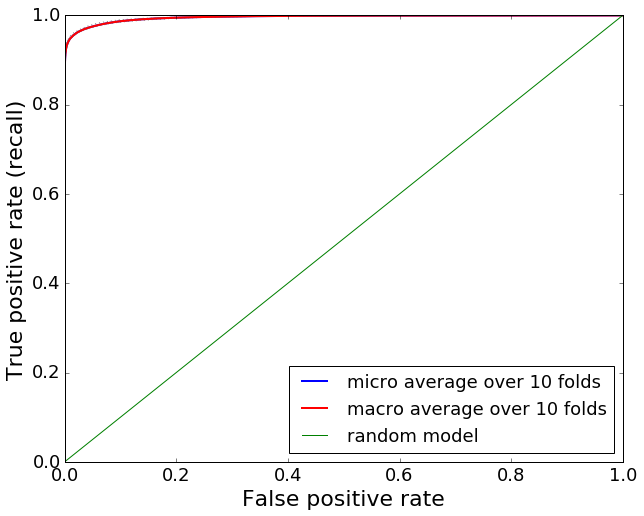

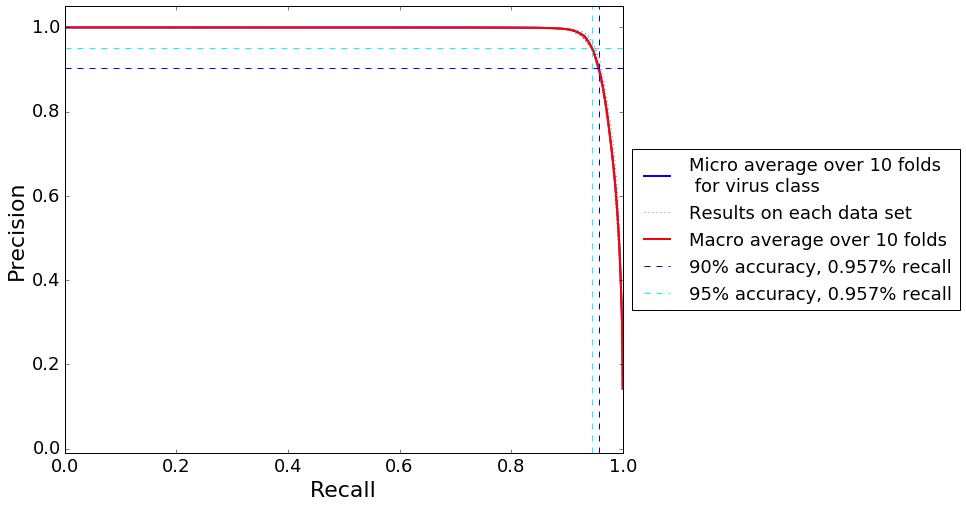

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy import interp

n_experiments=10

fig = plt.figure(figsize=[10,8])


## ROC CURVE

# 1) micro averaged ROC curve is straightfowrward -concatenate true labels -> concatenate probabilities -> draw.

all_labels = np.concatenate(roc_labels)
all_probas = np.concatenate(roc_probas)
fpr,tpr,thresh = roc_curve(all_labels,all_probas[:,1])
plt.plot(fpr,tpr,linewidth=2,label="micro average over 10 folds",color="blue")

print "Area under the microaveraged ROC curve is: ", roc_auc_score(all_labels,all_probas[:,1])


# for macro average, we need to gather the TP and FP rates for each experiment individually

FP_rates=[]
TP_rates=[]

areas=[] #we also keep track of the AUC to later validate
counts=[] #also just for validation purposes

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    #print np.shape(roc_labels[0]),np.shape(roc_probas[0][:,1])
    fpr,tpr,thresh = roc_curve(roc_labels[i],roc_probas[i][:,1])
    FP_rates.append(fpr)
    TP_rates.append(tpr)
    
    #print roc_auc_score(roc_labels[i],roc_probas[i][:,1])
    plt.plot(fpr,tpr,color="gray",linestyle="dotted")
    areas.append(roc_auc_score(roc_labels[i],roc_probas[i][:,1]))
    counts.append(len(roc_labels[i]))



# 3) Compute macro-average ROC curve and ROC area

# All experiments have values in different X-coordinates, to average we need to
# interpolate between known values.
# To do this, we first aggregate all used false positive rates (X-coordinates)
all_fpr = np.unique(np.concatenate([FP_rates[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_experiments):
    mean_tpr += interp(all_fpr, FP_rates[i], TP_rates[i])

# Finally average it and compute AUC
mean_tpr /= n_experiments
plt.plot(all_fpr,mean_tpr,linewidth=2,label="macro average over 10 folds",color="red")

plt.ylabel("True positive rate (recall)",fontsize=22)
plt.xlabel("False positive rate",fontsize=22)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=4,fontsize=18)

print "Area under the macroaveraged ROC curve is: ", auc(all_fpr, mean_tpr)


#
#-----------------------------------------------------------------------------
# PRECISION - RECALL curve
#-----------------------------------------------------------------------------
#

plt.figure(figsize=[10,8])
ax = plt.subplot(111)

# 1) again micro-averaging is easy:
precision_vir,recall_vir,thresh = precision_recall_curve(all_labels,all_probas[:,1])
ax.plot(recall_vir,precision_vir,color="blue",label="Micro average over 10 folds \n for virus class",linewidth=2)


# save virus and non-virus precision and recalls experiment per experiment in here
experiment_v_precs=[]
experiment_v_recs=[]
experiment_nv_precs=[]
experiment_nv_recs=[]

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    prec_v,rec_v,thresh = precision_recall_curve(roc_labels[i],roc_probas[i][:,1])
    prec_nv,rec_nv,thresh = precision_recall_curve(np.abs(roc_labels[i]-1),roc_probas[i][:,0])
    experiment_v_precs.append(prec_v)
    experiment_v_recs.append(rec_v)
    experiment_nv_precs.append(prec_nv)
    experiment_nv_recs.append(rec_nv)

    ax.plot(rec_v,prec_v,color="gray",linestyle="dotted")

#draw the last line again, simply to make an entry to the legend
ax.plot(rec_v,prec_v,color="gray",linestyle="dotted",label="Results on each data set")



# 3) Compute macro-average precision-recall curve and AUC

# All experiments have values in different X-coordinates, to get an average we need to
# interpolate between known values.

# To do this, we first aggregate all used recall rates (X-coordinates)
all_v_rec = np.unique(np.concatenate([experiment_v_recs[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_precisions = np.zeros_like(all_v_rec)
for i in range(n_experiments):
    # NOTICE: to use interpolate, the x-axis values need to be sorted increasingly,
    # so we need to reverse the arrays
    mean_precisions += interp(all_v_rec, experiment_v_recs[i][::-1], experiment_v_precs[i][::-1])


# Finally average it and compute AUC
mean_precisions /= n_experiments
plt.plot(all_v_rec,mean_precisions,linewidth=2,label="Macro average over 10 folds",color="red")


print "\n\nArea under the micro-averaged PRECISION-REC curve is:", auc(recall_vir,precision_vir)
print "Area under the macro-averaged PRECISION-REC curve is: ", auc(all_v_rec, mean_precisions)


ax.set_xlabel('Recall',fontsize=22)
ax.set_ylabel('Precision',fontsize=22)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.tick_params(axis='both', labelsize=18)
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

# 4) we also add lines to the plot do demonstate the trade-off at certain values 
id74 = np.min(np.where(precision_vir>0.74)[0])
print "at precision 0.74  ", precision_vir[id74]," we have recall of: ",recall_vir[id74]
id90 = np.min(np.where(precision_vir>0.9)[0])
print "at precision 0.9  ", precision_vir[id90]," we have recall of: ",recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print "at precision 0.95  ",precision_vir[id95]," we have recall of: ",recall_vir[id95]
ax.axhline(precision_vir[id90],linestyle="--",label="90% accuracy, "+str(np.round(recall_vir[id90],3))+"% recall")
ax.axvline(recall_vir[id90],linestyle="--")
ax.axhline(precision_vir[id95],color="cyan",linestyle="--",label="95% accuracy, "+str(np.round(recall_vir[id90],3))+"% recall")
ax.axvline(recall_vir[id95],color="cyan",linestyle="--")
ax.legend(loc="center left",bbox_to_anchor=(1,0.5),fontsize=18)

plt.show()


## TRAIN ON GenBank DATA, TEST ON metagenomics

In [5]:
GB_features = loadtxt("data/new_data/genbank/matrix.txt",delimiter=",")
GB_labels = loadtxt("data/new_data/genbank/values.txt",dtype=int)

print "genbank data shape: ",GB_features.shape, GB_labels.shape, "\n genbank counts of classes ", np.bincount(GB_labels)


#TEST ON MetaGenomics DATA
folder="data/new_data/concat_al2"
if "concat_al2" in folder:
    #seqID1 = loadtxt(folder[:-10]+"forward_al2/RSCU_id.txt",dtype=str)
    features1 = loadtxt(folder[:-10]+"forward_al2/matrix.txt")
    labels1 = loadtxt(folder[:-10]+"forward_al2/values.txt",dtype=int)
        
    features2 = loadtxt(folder[:-10]+"reverse_al2/matrix.txt")
    labels2 = loadtxt(folder[:-10]+"reverse_al2/values.txt",dtype=int)
    #seqID2 = loadtxt(folder[:-10]+"reverse_al2/RSCU_id.txt",dtype=str)

    features = np.concatenate([features1,features2])
    labels = np.concatenate([labels1,labels2])
    #seqID = np.concatenate([seqID1,seqID2])
 
    #projects,exp_names=seqID_to_projects(seqID)
        
else:
    print " NOT SUPPORTED!! We do LOO only on concat_al2 right now"
    assert(False)
        
print "metagenomics data shape: ",features.shape, labels.shape, "\n metagenomics counts of classes ", np.bincount(labels)
    


#Train model on whole DNA dataset, then test on new
rf = RandomForestClassifier(n_estimators=100, n_jobs=3)
rf.fit(GB_features, GB_labels)



print "#################################################"

pred_new = rf.predict(features)
prob_new = rf.predict_proba(features)
report = classification_report(labels, pred_new, target_names=["not virus", "virus"])

print "report at 0.5: \n", report

genbank data shape:  (631982, 59) (631982,) 
 genbank counts of classes  [541999  89983]
metagenomics data shape:  (188601, 59) (188601,) 
 metagenomics counts of classes  [182936   5665]
#################################################
report at 0.5: 
             precision    recall  f1-score   support

  not virus       0.97      1.00      0.98    182936
      virus       0.39      0.03      0.05      5665

avg / total       0.95      0.97      0.96    188601



Area under the ROC curve is:  0.50964108438


Area under the micro-averaged PRECISION-REC curve is: 0.0580687879753
at precision 0.74   1.0  we have recall of:  0.0
at precision 0.9   1.0  we have recall of:  0.0
at precision 0.95   1.0  we have recall of:  0.0


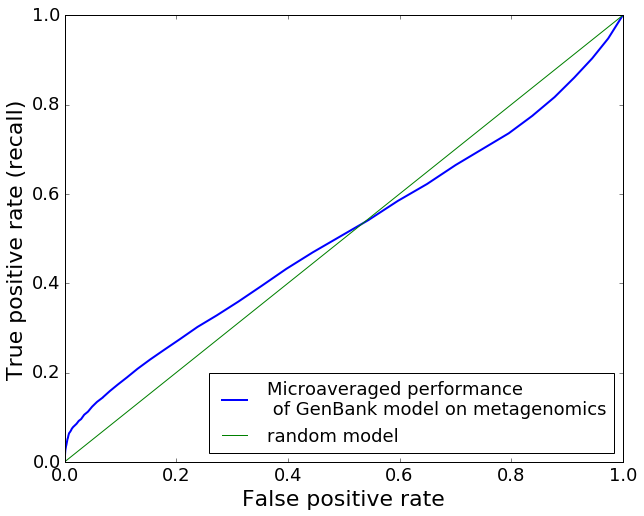

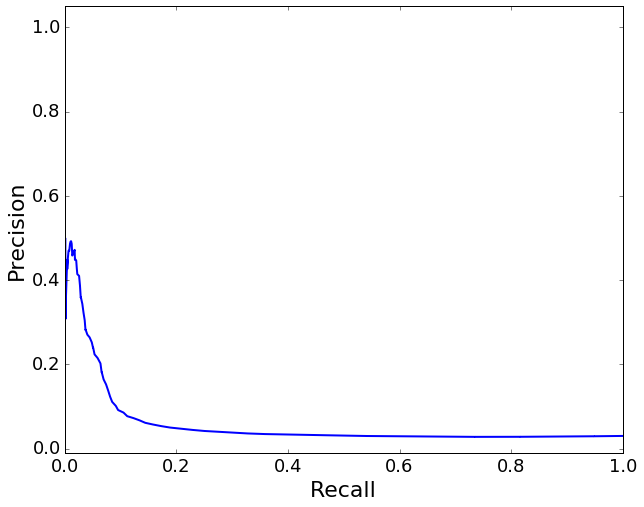

In [6]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy import interp 
fig = plt.figure(figsize=[10,8])

fpr,tpr,thresh = roc_curve(labels,prob_new[:,1])
plt.plot(fpr,tpr,linewidth=2,label="Microaveraged performance \n of GenBank model on metagenomics",color="blue")

print "Area under the ROC curve is: ", roc_auc_score(labels,prob_new[:,1])

plt.ylabel("True positive rate (recall)",fontsize=22)
plt.xlabel("False positive rate",fontsize=22)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=4,fontsize=18)



plt.figure(figsize=[10,8])
ax = plt.subplot(111)

# 1) again micro-averaging is easy:
precision_vir,recall_vir,thresh = precision_recall_curve(labels,prob_new[:,1])
ax.plot(recall_vir,precision_vir,color="blue",label="Micro average (over experiments)\n for virus class",linewidth=2)


print "\n\nArea under the micro-averaged PRECISION-REC curve is:", auc(recall_vir,precision_vir)

ax.set_xlabel('Recall',fontsize=22)
ax.set_ylabel('Precision',fontsize=22)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.tick_params(axis='both', labelsize=18)
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

# 4) we also add lines to the plot do demonstate the trade-off at certain values 
id74 = np.min(np.where(precision_vir>0.74)[0])
print "at precision 0.74  ", precision_vir[id74]," we have recall of: ",recall_vir[id74]
id90 = np.min(np.where(precision_vir>0.9)[0])
print "at precision 0.9  ", precision_vir[id90]," we have recall of: ",recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print "at precision 0.95  ",precision_vir[id95]," we have recall of: ",recall_vir[id95]


In [7]:
report = classification_report(labels, pred_new, target_names=["not virus", "virus"])
print "report at 0.5: \n", report

report at 0.5: 
             precision    recall  f1-score   support

  not virus       0.97      1.00      0.98    182936
      virus       0.39      0.03      0.05      5665

avg / total       0.95      0.97      0.96    188601



## Train on Metagenomics and test on GenBank

In [15]:
GB_features = loadtxt("data/new_data/genbank/matrix.txt",delimiter=",")
GB_labels = loadtxt("data/new_data/genbank/values.txt",dtype=int)

print "genbank data shape: ",GB_features.shape, GB_labels.shape, "\n genbank counts of classes ", np.bincount(GB_labels)


#TEST ON MetaGenomics DATA
folder="data/new_data/concat_al2"
if "concat_al2" in folder:
    #seqID1 = loadtxt(folder[:-10]+"forward_al2/RSCU_id.txt",dtype=str)
    features1 = loadtxt(folder[:-10]+"forward_al2/matrix.txt")
    labels1 = loadtxt(folder[:-10]+"forward_al2/values.txt",dtype=int)
        
    features2 = loadtxt(folder[:-10]+"reverse_al2/matrix.txt")
    labels2 = loadtxt(folder[:-10]+"reverse_al2/values.txt",dtype=int)
    #seqID2 = loadtxt(folder[:-10]+"reverse_al2/RSCU_id.txt",dtype=str)

    features = np.concatenate([features1,features2])
    labels = np.concatenate([labels1,labels2])
    #seqID = np.concatenate([seqID1,seqID2])
 
    #projects,exp_names=seqID_to_projects(seqID)
        
else:
    print " NOT SUPPORTED!! We do LOO only on concat_al2 right now"
    assert(False)
        
print "metagenomics data shape: ",features.shape, labels.shape, "\n metagenomics counts of classes ", np.bincount(labels)
    


#Train model on whole DNA dataset, then test on new
rf = RandomForestClassifier(n_estimators=500, n_jobs=3)
rf.fit(features, labels)



print "#################################################"

pred_new = rf.predict(GB_features)
prob_new = rf.predict_proba(GB_features)
report = classification_report(GB_labels, pred_new, target_names=["not virus", "virus"])

print "report at 0.5: \n", report

genbank data shape:  (631982, 59) (631982,) 
 genbank counts of classes  [541999  89983]
metagenomics data shape:  (188601, 59) (188601,) 
 metagenomics counts of classes  [182936   5665]
#################################################
report at 0.5: 
             precision    recall  f1-score   support

  not virus       0.86      1.00      0.92    541999
      virus       0.80      0.00      0.00     89983

avg / total       0.85      0.86      0.79    631982



Area under the ROC curve is:  0.554730378516


Area under the micro-averaged PRECISION-REC curve is: 0.159295432153
at precision 0.74   0.741610738255  we have recall of:  0.00245601947034
at precision 0.9   0.907284768212  we have recall of:  0.00152250980741
at precision 0.95   0.951048951049  we have recall of:  0.00151139659714


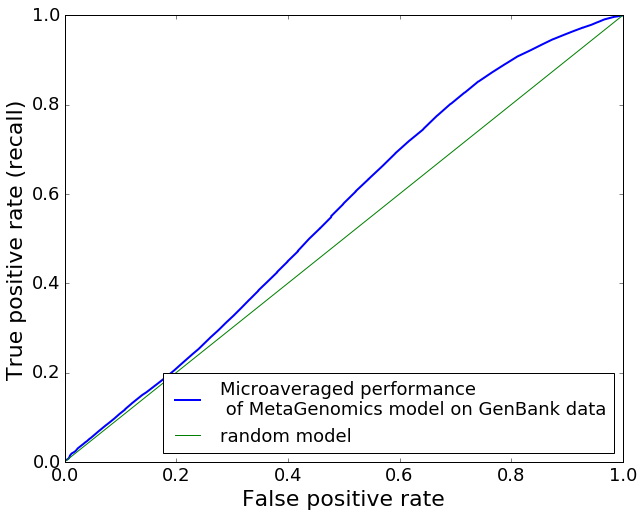

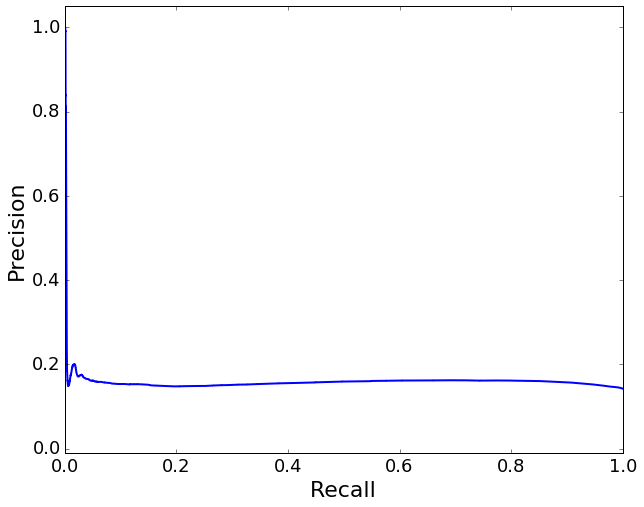

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy import interp 
fig = plt.figure(figsize=[10,8])

fpr,tpr,thresh = roc_curve(GB_labels,prob_new[:,1])
plt.plot(fpr,tpr,linewidth=2,label="Microaveraged performance \n of MetaGenomics model on GenBank data",color="blue")

print "Area under the ROC curve is: ", roc_auc_score(GB_labels,prob_new[:,1])

plt.ylabel("True positive rate (recall)",fontsize=22)
plt.xlabel("False positive rate",fontsize=22)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=4,fontsize=18)



plt.figure(figsize=[10,8])
ax = plt.subplot(111)

# 1) again micro-averaging is easy:
precision_vir,recall_vir,thresh = precision_recall_curve(GB_labels,prob_new[:,1])
ax.plot(recall_vir,precision_vir,color="blue",label="Micro average for virus class",linewidth=2)


print "\n\nArea under the micro-averaged PRECISION-REC curve is:", auc(recall_vir,precision_vir)

ax.set_xlabel('Recall',fontsize=22)
ax.set_ylabel('Precision',fontsize=22)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.tick_params(axis='both', labelsize=18)
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

# 4) we also add lines to the plot do demonstate the trade-off at certain values 
id74 = np.min(np.where(precision_vir>0.74)[0])
print "at precision 0.74  ", precision_vir[id74]," we have recall of: ",recall_vir[id74]
id90 = np.min(np.where(precision_vir>0.9)[0])
print "at precision 0.9  ", precision_vir[id90]," we have recall of: ",recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print "at precision 0.95  ",precision_vir[id95]," we have recall of: ",recall_vir[id95]
